In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Merge all processed csv file into a dataframe and convert date column to datetime 

In [2]:
df_list =[]
for file in os.listdir('raw_data/'):
    if 'processed_csv_' in file:
        df = pd.read_csv('raw_data/{}'.format(file))
        df_list.append(df)

df_all = pd.concat(df_list)
df_all['date'] = pd.to_datetime(df_all['date'],errors='coerce')
df_all['datetime'] = df_all['date'] + df_all['time'].astype('timedelta64[h]')
df_list = None
df_all.head()

,date,time,entrance,exit,people,code_entrance,code_exit,weekday,datetime
0,2020-09-01,0,松山機場,台北車站,0,BR13,BL12,1,2020-09-01
1,2020-09-01,0,松山機場,市政府,0,BR13,BL18,1,2020-09-01
2,2020-09-01,0,中山國中,台北車站,1,BR12,BL12,1,2020-09-01
3,2020-09-01,0,中山國中,市政府,1,BR12,BL18,1,2020-09-01
4,2020-09-01,0,南京復興,台北車站,0,G16,BL12,1,2020-09-01


In [3]:
df_all.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3627320 entries, 0 to 306799
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   time           int64         
 2   entrance       object        
 3   exit           object        
 4   people         int64         
 5   code_entrance  object        
 6   code_exit      object        
 7   weekday        int64         
 8   datetime       datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 1.2 GB


## 2. Remove national holidays and weekends

In [4]:
holidays = ['01-01','01-23','01-24','01-27','01-28',
          '01-29','02-28','04-02','04-03','05-01',
          '06-25','06-26','10-01','10-02','10-09']
holidays = '|'.join(holidays)

df_workday = df_all[ ~( (df_all['date'].astype(str).str.contains(holidays)) | (df_all['weekday'].isin([5,6])) ) ].copy()
df_workday['datetime'] = df_workday['date'] + df_workday['time'].astype('timedelta64[h]')
df_workday.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2448264 entries, 0 to 306799
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   time           int64         
 2   entrance       object        
 3   exit           object        
 4   people         int64         
 5   code_entrance  object        
 6   code_exit      object        
 7   weekday        int64         
 8   datetime       datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 807.8 MB


## 3. Check numbers with other sources
 - https://www.ptt.cc/bbs/MRT/M.1610699361.A.B6B.html

In [72]:
station = '市政府'
df_check = df_all[(df_all['entrance']==station)|(df_all['exit']==station)]\
.groupby(['date','time'],as_index=False)[['people']].sum()

df_check[df_check['date'].dt.month==12]['people'].sum()/30

144334.2

## 4. Visualize

In [6]:
def fill_holidays(df, weekend_list, axis_idx):
    for weekend in weekend_list:
        d = df[(df['date'].dt.day >= weekend[0]) & (df['date'].dt.day <= weekend[1])]['date'].values
        axis_idx.fill_between(d, 0, max_people, facecolor='red', alpha=0.10)

/Users/unhumanWu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/unhumanWu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


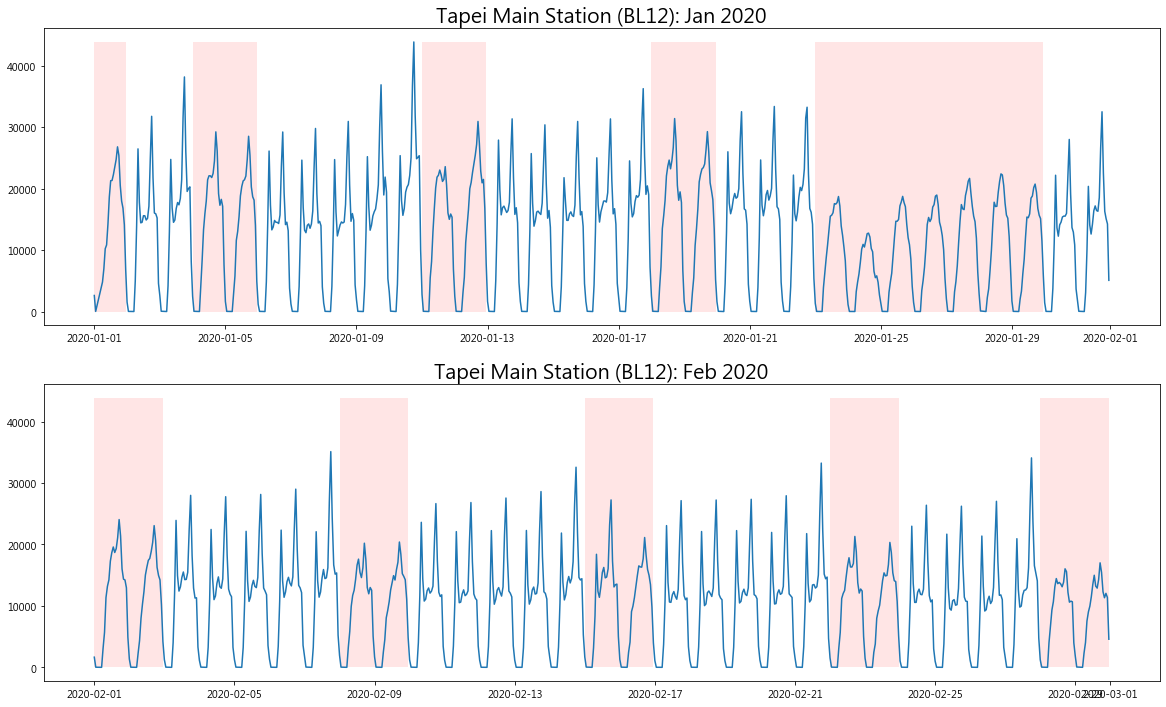

In [7]:
station = '台北車站'
plot_title = 'Tapei Main Station (BL12)'

df_hourly = df_all[(df_all['entrance']==station)|(df_all['exit']==station)]\
.groupby(['date','time'],as_index=False)[['people']].sum()

df_hourly['date'] = df_hourly['date'] + df_hourly['time'].astype('timedelta64[h]')

df_plot1 = df_hourly[(df_hourly['date'].dt.month==1) & (df_hourly['date'].dt.day < 32)]
df_plot1['weekday'] = df_plot1['date'].dt.weekday

df_plot2 = df_hourly[(df_hourly['date'].dt.month==2) & (df_hourly['date'].dt.day < 32)]
df_plot2['weekday'] = df_plot2['date'].dt.weekday

max_people = max(df_plot2['people'].max(), df_plot1['people'].max())

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20, 12))

ax1_weekends = [[1,1],[4,5],[11,12],[18,19],[23,29]]
ax1.plot(df_plot1['date'], df_plot1['people'])
ax1.set_title('{}: Jan 2020'.format(plot_title), fontsize=20)
fill_holidays(df_plot1, ax1_weekends, ax1)

ax2_weekends = [[1,2],[8,9],[15,16],[22,23],[28,29]]
ax2.plot(df_plot2['date'], df_plot2['people'])
ax2.set_title('{}: Feb 2020'.format(plot_title), fontsize=20)
fill_holidays(df_plot2, ax2_weekends, ax2)

## 5. Export data for model 

In [22]:


def export_traffic_data_for_model(df_input, extract_station):

    df_out = df_input[ (df_input['entrance']==extract_station)|(df_input['exit']==extract_station) ]
    #display(df_out)
    df_out = df_out.groupby(['date','time'],as_index=False)[['people']].sum()
    
    return df_out
    
station='台北車站' #Taipei Main Station (BL12)
df_tm = export_traffic_data_for_model(df_input=df_all,
                                                       extract_station=station)
df_tm.to_csv('data/traffic_tms_all.csv', index=False)


station='市政府' #Taipei City Hall (BL18)
df_tm = export_traffic_data_for_model(df_input=df_all,
                                                       extract_station=station)
df_tm.to_csv('data/traffic_tch_all.csv', index=False)